In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

X = flat array of standardized heights <br>
Y = flat array of weight (non standardized) <br>
tx = (1000,2) array [0] = column of 1's [1] = standardized heights

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


**What does each column of $\bar{X}$ represent?**<br>
col[0] is a stand in for the bias term or $w_{0}$ in the regression <br>
col[1] is all the standardized heights 

**What does each row of $\bar{X}$ represent?**<br>
1 row represents the bias term and one persons height

**Why do we have 1's in $\bar{X}$?**<br>
This column is added to make computing a guess and compute the loss easier. We will take the 1's * $w_{0}$ which represents the bias term in linear regression

**If we have heights and weights of 3 people, what would be the size of y and $\bar{X}$? What would $\bar{X}_{32}$ represet?**<br>
y = (3,1)<br>
$\bar{X}$ = (3,2)

$\bar{X}_{32}$  represent the standardized height of the person whose data is recorded in the 3rd row.

In [4]:
def mse(y, y_hat):
    return np.sum((y - y_hat)**2) / (2 * len(y_hat))
    
def mae(y, y_hat):
    return np.sum(np.abs(y - y_hat)) / len(y_hat)

In [5]:
def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    y_hat = np.sum(tx * w,axis=1)
    return mse(y, y_hat)

In [6]:
compute_loss(y, tx, np.array([1,2]))

2694.4833658870843

# 2 Grid Search

Fill in the function `grid_search()` below:

In [7]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    
    for i in range(len(w0)):
        for j in range(len(w1)):
            w = np.array([w0[i],w1[j]])
            losses[i][j] = compute_loss(y, tx, w)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.55870336860953, w0*=72.72727272727272, w1*=13.636363636363626, execution time=1.613 seconds


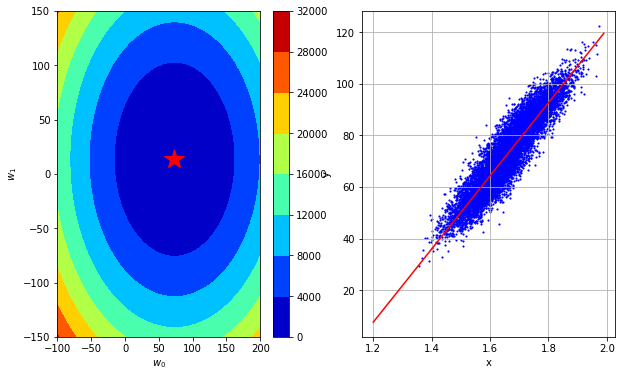

In [8]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=100)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

**Do you need a coarse or fine grid to obtain an accurate fit?** <br>
Fine grid. Coarse grid has lots of jumps between values and doesn't get you as close to a global minimum. 

**What do you observe with different values of grid spacing?** <br>
**How does increasing the number of values affect computational cost? How fast or slow does your code run?**<br>
It gets more accurate but the code really runs slower due to the exponential time double for loop of grid search. For example a granularity of 500 gives me a 40 second running time and a loss of 15.39.
A granularity of 100 gives me a 1.6 second running time and a loss of 15.5 . You definitely reach a point of diminishing marginal returns.

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [9]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    y_hat = np.sum(tx * w,axis=1)
    N = len(tx)
    e = y - y_hat

    gradient = (-1/N) * tx.T.dot(e)
    
    return gradient

In [10]:
compute_gradient(y, tx, np.array([400,400]))

array([326.706078  , 386.52028757])

**What do the values of the gradients tell us? Think about norm? In which cases are they bigger? What does this mean?** <br>
I imagine 3D space where x and y axis are values of w0 and w1 and the Z axis is the total MSE given by w0 and w1. This would create some sort of convex curved plane (given that MSE is convex). The gradients tell us the slope of the line tangent to the plane at the point we are at. <br>

For w0 the gradient is actually just the average of the error term. So w0 and w1s that on average create larger errors will mean a larger gradient for the w0 term. 

For w1 the gradient is the error term at a point * the value of the point.  

A larger gradient means a steeper slope 

The euclidian norm of a vector is the length of the vector from tail to tip. The norm of the gradient vector would represent the length of this vector. The larger the values the greater the lenght. As you get closer to a global minimum the norm get smaller and smaller because the gradient vector is getting smaller.

our gradient defines the slope of a line and it is always a global underestimator of f.

For a differentiable function, it is possible to find relationships between the two variables - by what amount one variable changes and in what direction, when the other one is modified using the derivative. 

Please fill in the functions `gradient_descent` below:

In [11]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        
        loss = compute_loss(y, tx, ws[n_iter])
        gradient = compute_gradient(y, tx, ws[n_iter])
        
        w = ws[n_iter] - gamma * gradient

        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [12]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = .1

# Initialization
w_initial = np.array([10, 10])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2024.500368388226, w0=16.32939220021052, w1=10.347971243498893
Gradient Descent(1/49): loss=1642.7686170895402, w0=22.025845180399987, w1=10.661145362647902
Gradient Descent(2/49): loss=1333.5658985376053, w0=27.15265286257051, w1=10.94300206988201
Gradient Descent(3/49): loss=1083.1116965105377, w0=31.76677977652398, w1=11.196673106392709
Gradient Descent(4/49): loss=880.2437928686131, w0=35.91949399908211, w1=11.424977039252337
Gradient Descent(5/49): loss=715.920790918654, w0=39.65693679938442, w1=11.630450578826004
Gradient Descent(6/49): loss=582.8191593391872, w0=43.02063531965649, w1=11.815376764442306
Gradient Descent(7/49): loss=475.00683775981923, w0=46.04796398790136, w1=11.981810331496977
Gradient Descent(8/49): loss=387.67885728053125, w0=48.77255978932175, w1=12.131600541846183
Gradient Descent(9/49): loss=316.9431930923078, w0=51.22469601060009, w1=12.266411731160465
Gradient Descent(10/49): loss=259.64730509984696, w0=53.4316186097506, w1=12

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

**Try varying step size, what did you observe?**<br>
If the step size it too small we don't converge to a minimum in the our max iters. We would need more iterations to be able to coverge. There is definitely a sweet spot.

If gamma is too large than everything seems to explode and we don't coverge. 

**Different initializations**<br>
It is better to start closer to the proper weights and takes less time to converge. If we start too far away with a small step size and few iterations we won't be anywhere near minimum

# 4 Stochastic gradient descent

In [14]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    y_hat = np.sum(tx * w,axis=1)
    N = len(tx)
    e = y - y_hat

    gradient = (-1/N) * tx.T.dot(e)
    
    return gradient


def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    losses = []
    ws = [initial_w]
    
    for i in range(max_iters):
        loss = compute_loss(y, tx, ws[i])
        
        for batch_y, batch_tx in batch_iter(y, tx, batch_size):
            gradient = compute_gradient(batch_y, batch_tx, ws[i])
            w = ws[i] - gamma * gradient
        
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=i, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
        losses.append(loss)
        ws.append(w)
            
    return losses, ws

In [15]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
n_iters = 100
gamma = 0.3
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, n_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/99): loss=2792.2367127591674, w0=26.082057640243804, w1=9.559267773981494
Gradient Descent(1/99): loss=1137.550899300239, w0=41.88679652335362, w1=37.12193666964575
Gradient Descent(2/99): loss=788.0670366687477, w0=56.37241418967983, w1=32.92802952754145
Gradient Descent(3/99): loss=347.67312005804894, w0=65.24021152071113, w1=30.95977482166336
Gradient Descent(4/99): loss=200.59330464890087, w0=68.60251185591774, w1=28.69528828704137
Gradient Descent(5/99): loss=142.14742670348366, w0=70.95679224910872, w1=28.29669070537776
Gradient Descent(6/99): loss=127.88839814258576, w0=76.69416528379627, w1=21.670288244076673
Gradient Descent(7/99): loss=54.70948109837773, w0=79.28525265641093, w1=18.89490538923023
Gradient Descent(8/99): loss=47.99606673927288, w0=78.04800584254943, w1=17.178217553698488
Gradient Descent(9/99): loss=33.52601450637587, w0=74.19944687116026, w1=15.130747198980417
Gradient Descent(10/99): loss=17.15883340902202, w0=72.45568374900625, w1=14.4457

In [16]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=101, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# 5 Effect of Outliers

### Exercise 5


In [17]:
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

Text(0, 0.5, 'Weight')

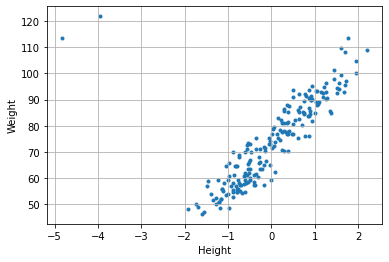

In [18]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.scatter(tx[:,1], weight, marker='.')
ax1.grid()
ax1.set_xlabel('Height')
ax1.set_ylabel('Weight')

In [19]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = .5

# Initialization
w_initial = np.array([10, 10])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2118.808107326697, w0=42.033902927463195, w1=10.517447432994583
Gradient Descent(1/49): loss=579.1500744086264, w0=58.050854391194775, w1=10.776171149491859
Gradient Descent(2/49): loss=194.2355661791092, w0=66.05933012306058, w1=10.905533007740488
Gradient Descent(3/49): loss=98.00693912172979, w0=70.06356798899347, w1=10.9702139368648
Gradient Descent(4/49): loss=73.94978235738499, w0=72.06568692195992, w1=11.002554401426954
Gradient Descent(5/49): loss=67.93549316629878, w0=73.06674638844315, w1=11.018724633708029
Gradient Descent(6/49): loss=66.4319208685272, w0=73.56727612168476, w1=11.026809749848566
Gradient Descent(7/49): loss=66.05602779408433, w0=73.81754098830557, w1=11.030852307918835
Gradient Descent(8/49): loss=65.96205452547362, w0=73.94267342161596, w1=11.032873586953968
Gradient Descent(9/49): loss=65.93856120832095, w0=74.00523963827116, w1=11.033884226471535
Gradient Descent(10/49): loss=65.93268787903276, w0=74.03652274659876, w1=11.0343

In [20]:
gd_w = gradient_ws[-1]

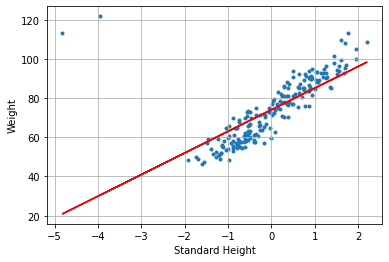

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.scatter(tx[:,1], weight, marker='.')
ax1.grid()
ax1.set_xlabel('Standard Height')
ax1.set_ylabel('Weight')

ax1.plot(x,gd_w[0]+gd_w[1]*x,color='r')

**Does it look like a good fit**<br>
Nope, the outliers are definitely causing problems. Its because the errors are squared in MSE and therefore these outliers being far away are having an outsized impact on our gradients in comparison to the other points. 

# 6 Subgradient Descent

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)

In [22]:
def compute_loss(y, tx, w, error_fn = 'MSE'):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    y_hat = np.sum(tx * w,axis=1)
    if error_fn == 'MSE':
        error = mse(y, y_hat)
    elif error_fn == 'MAE':
        error = mae(y, y_hat)
    else:
        print('Did not match a loss function')
        error = np.array([0,0])
    return error

In [38]:
def compute_subgradient(y, tx, w):
    N = len(tx)
    y_hat = np.sum(tx * w, axis = 1)
    
    e = y - y_hat
    
    if np.sum(e) != 0:
        return (-1/N)*tx.T.dot(e / np.abs(e))
    else:
        #Return vector between [-1,1]
        print('At non-differentiable point, e is 0')
        return np.array([-.5, -.5])

In [39]:
w = np.array([5,5])
compute_subgradient(y[[0]], tx[[0]], w)

array([-1.        , -1.60732851])

In [40]:
def gradient_descent_mae(y, tx, w_initial, gamma, max_iter = 50):
    losses = []
    weights = [w_initial]
    
    for i in range(max_iter):
        gradient = compute_subgradient(y, tx, weights[i])
        w = weights[i] - gamma * gradient
        
        losses.append(compute_loss(y, tx, weights[i],error_fn = 'MAE'))
        weights.append(w)
        
        print('GD {}/{}  Loss: {:.5f}  w0 = {:.3f}  w1 = {:.3f}'.format(i+1,max_iter,losses[i],weights[i][0],weights[i][1]))
        
    return weights, losses

In [41]:
def stochastic_gradient_descent_mae(y, tx, w_initial, batch_size, gamma, max_iter = 50):
    losses = []
    weights = [w_initial]
    
    for i in range(max_iter):
        
        for batch_y, batch_tx in batch_iter(y, tx, batch_size):
            gradient = compute_subgradient(batch_y, batch_tx, weights[i])
            w = weights[i] - gamma * gradient
        
        losses.append(compute_loss(y, tx, weights[i],error_fn = 'MAE'))
        weights.append(w)
        
        print('SGD {}/{}  Loss: {:.5f}  w0 = {:.3f}  w1 = {:.3f}'.format(i+1,max_iter,losses[i],weights[i][0],weights[i][1]))
        
    return weights, losses

In [49]:
gamma = .3
w_initial = np.array([5,5])
n_iter = 300
mae_gd_gradient, mae_gd_losses = gradient_descent_mae(y, tx, w_initial, gamma, max_iter = n_iter)

GD 1/300  Loss: 69.06781  w0 = 5.000  w1 = 5.000
GD 2/300  Loss: 68.76781  w0 = 5.300  w1 = 5.000
GD 3/300  Loss: 68.46781  w0 = 5.600  w1 = 5.000
GD 4/300  Loss: 68.16781  w0 = 5.900  w1 = 5.000
GD 5/300  Loss: 67.86781  w0 = 6.200  w1 = 5.000
GD 6/300  Loss: 67.56781  w0 = 6.500  w1 = 5.000
GD 7/300  Loss: 67.26781  w0 = 6.800  w1 = 5.000
GD 8/300  Loss: 66.96781  w0 = 7.100  w1 = 5.000
GD 9/300  Loss: 66.66781  w0 = 7.400  w1 = 5.000
GD 10/300  Loss: 66.36781  w0 = 7.700  w1 = 5.000
GD 11/300  Loss: 66.06781  w0 = 8.000  w1 = 5.000
GD 12/300  Loss: 65.76781  w0 = 8.300  w1 = 5.000
GD 13/300  Loss: 65.46781  w0 = 8.600  w1 = 5.000
GD 14/300  Loss: 65.16781  w0 = 8.900  w1 = 5.000
GD 15/300  Loss: 64.86781  w0 = 9.200  w1 = 5.000
GD 16/300  Loss: 64.56781  w0 = 9.500  w1 = 5.000
GD 17/300  Loss: 64.26781  w0 = 9.800  w1 = 5.000
GD 18/300  Loss: 63.96781  w0 = 10.100  w1 = 5.000
GD 19/300  Loss: 63.66781  w0 = 10.400  w1 = 5.000
GD 20/300  Loss: 63.36781  w0 = 10.700  w1 = 5.000
GD 21/

In [50]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        mae_gd_losses, mae_gd_gradient, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(mae_gd_gradient)))

interactive(children=(IntSlider(value=1, description='n_iter', max=301, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

In [51]:
gamma = .3
w_initial = np.array([5,5])
batch_size = 1
n_iter = 300
mae_gradient, mae_losses = stochastic_gradient_descent_mae(y, tx, w_initial, batch_size, gamma, max_iter = n_iter)

SGD 1/300  Loss: 69.06781  w0 = 5.000  w1 = 5.000
SGD 2/300  Loss: 68.76781  w0 = 5.300  w1 = 5.098
SGD 3/300  Loss: 68.46781  w0 = 5.600  w1 = 5.210
SGD 4/300  Loss: 68.16781  w0 = 5.900  w1 = 5.300
SGD 5/300  Loss: 67.86781  w0 = 6.200  w1 = 5.734
SGD 6/300  Loss: 67.56781  w0 = 6.500  w1 = 5.552
SGD 7/300  Loss: 67.26781  w0 = 6.800  w1 = 5.664
SGD 8/300  Loss: 66.96781  w0 = 7.100  w1 = 5.948
SGD 9/300  Loss: 66.66781  w0 = 7.400  w1 = 6.268
SGD 10/300  Loss: 66.36781  w0 = 7.700  w1 = 6.333
SGD 11/300  Loss: 66.06781  w0 = 8.000  w1 = 6.168
SGD 12/300  Loss: 65.76781  w0 = 8.300  w1 = 5.922
SGD 13/300  Loss: 65.46781  w0 = 8.600  w1 = 5.979
SGD 14/300  Loss: 65.16781  w0 = 8.900  w1 = 6.017
SGD 15/300  Loss: 64.86781  w0 = 9.200  w1 = 5.836
SGD 16/300  Loss: 64.56781  w0 = 9.500  w1 = 6.073
SGD 17/300  Loss: 64.26781  w0 = 9.800  w1 = 5.929
SGD 18/300  Loss: 63.96781  w0 = 10.100  w1 = 6.210
SGD 19/300  Loss: 63.66781  w0 = 10.400  w1 = 6.049
SGD 20/300  Loss: 63.36781  w0 = 10.70

In [52]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        mae_losses, mae_gradient, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(mae_gradient)))

interactive(children=(IntSlider(value=1, description='n_iter', max=301, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

I noticed that I need more gradient descent iterations to get MAE to converge. MSE squares the error

In [45]:
mae_sgd_w = mae_gradient[-1]
mae_gd_w = mae_gd_gradient[-1]

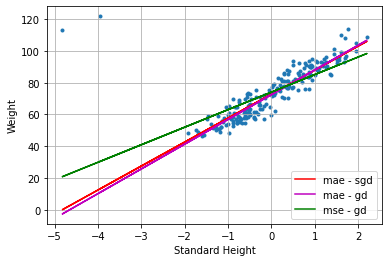

In [46]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.scatter(tx[:,1], weight, marker='.')
ax1.grid()
ax1.set_xlabel('Standard Height')
ax1.set_ylabel('Weight')

ax1.plot(x,mae_sgd_w[0]+mae_sgd_w[1]*x,color='r', label = 'mae - sgd')
ax1.plot(x,mae_gd_w[0]+mae_gd_w[1]*x,color='m', label = 'mae - gd')
ax1.plot(x,gd_w[0]+gd_w[1]*x,color='g', label = 'mse - gd')
ax1.legend()